# Reinforcement Learning and Value Iteration

Reinforcement Learning (RL) studies how an agent learns to make sequential decisions in an environment to maximize long-term reward. A common formalism is the Markov Decision Process (MDP), defined by:

- States (S): All possible configurations the agent can be in
- Actions (A): Choices available to the agent in each state
- Transition dynamics (P): Probability of moving to next state s' when taking action a in state s
- Reward (R): Immediate scalar feedback received after transitions
- Discount (γ ∈ [0,1)): Down-weights future rewards relative to immediate rewards

The goal is to find an optimal policy π*(s) that maximizes expected discounted return. Two key functions are:

- State-value Vπ(s): expected return following policy π from state s
- Action-value Qπ(s,a): expected return taking action a in s then following π

### Bellman Optimality

The optimal value function V*(s) satisfies the Bellman optimality equation:

$$\[$$ V^*(s) = \max_a \sum_{s'} P(s'\mid s,a) [ R(s,a,s') + \gamma V^*(s') ] $$

From V*, an optimal (greedy) policy can be derived by choosing the action that attains the maximum.

### Value Iteration (Used Here)

Value Iteration is a dynamic programming algorithm that repeatedly applies the Bellman optimality backup until values converge:

1. Initialize V(s) arbitrarily (e.g., zeros)
2. Repeat until convergence:
   - For each state s: $ V(s) \leftarrow \max_a \sum_{s'} P(s'\mid s,a) [ R(s,a,s') + \gamma V(s') ] $
3. Extract a greedy policy: $ \pi(s) = \arg\max_a \sum_{s'} P(s'\mid s,a) [ R(s,a,s') + \gamma V(s') ] $

### This Gridworld

- 5×5 states, deterministic transitions for the 4 actions (↑, ↓, ←, →)
- Hitting a wall: stay in place, reward −1
- Teleporters: A→A' gives +10, B→B' gives +5
- Discount γ = 0.9

We compute V* via value iteration and then build a greedy policy from V*. This illustrates how rewards and dynamics shape both the value landscape and optimal decisions.


In [1]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization theme consistent with other notebooks
sns.set_theme(font_scale=1.5)
sns.set_style("whitegrid", {"grid.linestyle": "--"})

# Grid size and discount factor
H, W = 5, 5
gamma = 0.9

# Teleporter positions and rewards
A, A_prime = (0, 1), (4, 1)
B, B_prime = (0, 3), (2, 3)
A_reward, B_reward = 10.0, 5.0

# Action definitions and display names
ACTIONS = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # up, down, left, right
A_NAMES = ["↑", "↓", "←", "→"]

def in_bounds(r: int, c: int) -> bool:
    """Determines whether a grid coordinate is inside the H×W grid.

    Args:
        r (int): Row index.
        c (int): Column index.

    Returns:
        bool: True if 0 ≤ r < H and 0 ≤ c < W; otherwise False.
    """
    return 0 <= r < H and 0 <= c < W

def step(state: tuple[int, int], aidx: int) -> tuple[tuple[int, int], float]:
    """Computes the next state and reward for a state-action pair.

    This function handles teleporter states A and B, wall collisions (stay with −1),
    and regular in-bounds moves (0 reward).

    Args:
        state (tuple[int, int]): Current state as (row, col).
        aidx (int): Index of action in ACTIONS (0: up, 1: down, 2: left, 3: right).

    Returns:
        tuple[tuple[int, int], float]: A pair of (next_state, reward).
    """
    r, c = state

    # Teleporters provide immediate reward and jump to target states
    if (r, c) == A:
        return A_prime, A_reward
    if (r, c) == B:
        return B_prime, B_reward

    # Regular transition
    dr, dc = ACTIONS[aidx]
    nr, nc = r + dr, c + dc

    # Hitting a wall: stay in place and receive −1
    if not in_bounds(nr, nc):
        return (r, c), -1.0

    # Normal in-bounds move: 0 reward
    return (nr, nc), 0.0

def value_iteration(theta: float = 1e-6, max_iter: int = 10000) -> tuple[np.ndarray, np.ndarray]:
    """Runs Value Iteration to compute V* and its greedy policy.

    Iteratively applies the Bellman optimality update until values converge, then
    extracts a greedy policy with respect to the converged values.

    Args:
        theta (float): Convergence threshold on max-norm change in V. Defaults to 1e-6.
        max_iter (int): Maximum number of iterations to prevent infinite loops. Defaults to 10000.

    Returns:
        tuple[np.ndarray, np.ndarray]:
            - V (H×W float array): Optimal state values V*.
            - Pi (H×W int array): Greedy policy indices (0..3) corresponding to ACTIONS.
    """
    V = np.zeros((H, W), dtype=float)

    # Value updates until convergence or iteration limit
    for _ in range(max_iter):
        delta = 0.0
        V_old = V.copy()
        for r in range(H):
            for c in range(W):
                # One-step lookahead for all actions
                q_vals = []
                for a in range(len(ACTIONS)):
                    (nr, nc), rwd = step((r, c), a)
                    q_vals.append(rwd + gamma * V_old[nr, nc])
                # Bellman optimality backup
                V[r, c] = float(np.max(q_vals))
                delta = max(delta, abs(V[r, c] - V_old[r, c]))
        if delta < theta:
            break

    # Greedy policy extraction from converged values
    Pi = np.zeros((H, W), dtype=int)
    for r in range(H):
        for c in range(W):
            q_vals = []
            for a in range(len(ACTIONS)):
                (nr, nc), rwd = step((r, c), a)
                q_vals.append(rwd + gamma * V[nr, nc])
            Pi[r, c] = int(np.argmax(q_vals))

    return V, Pi

# Compute optimal values and greedy policy
V, Pi = value_iteration()
V


array([[21.97748351, 24.41942612, 21.97748351, 19.41942612, 17.47748351],
       [19.77973516, 21.97748351, 19.77973516, 17.80176164, 16.02158458],
       [17.80176164, 19.77973516, 17.80176164, 16.02158458, 14.41942612],
       [16.02158458, 17.80176164, 16.02158458, 14.41942612, 12.97748351],
       [14.41942612, 16.02158458, 14.41942612, 12.97748351, 11.67973516]])

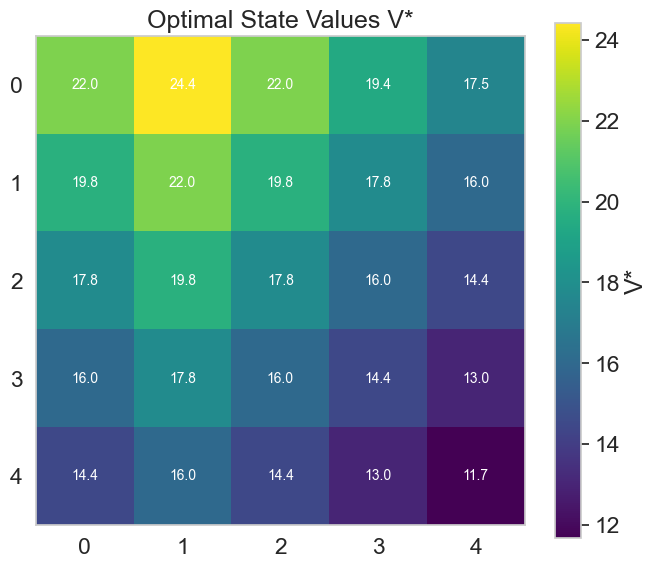

In [2]:

plt.figure(figsize=(7, 6))
plt.imshow(V, origin="upper", cmap="viridis")
plt.colorbar(label="V*")
plt.title("Optimal State Values V*")

# Overlay state values
for r in range(H):
    for c in range(W):
        plt.text(c, r, f"{V[r, c]:.1f}", ha="center", va="center", color="white", fontsize=10)

plt.xticks(range(W))
plt.yticks(range(H))
plt.grid(False)
plt.tight_layout()
plt.show()


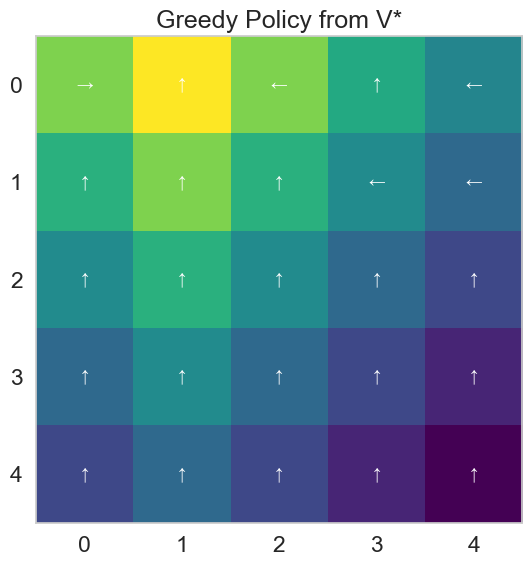

In [3]:

plt.figure(figsize=(7, 6))
plt.imshow(V, origin="upper", cmap="viridis")
plt.title("Greedy Policy from V*")

# Overlay greedy action arrows
for r in range(H):
    for c in range(W):
        plt.text(c, r, A_NAMES[Pi[r, c]], ha="center", va="center", color="white", fontsize=12)

plt.xticks(range(W))
plt.yticks(range(H))
plt.grid(False)
plt.tight_layout()
plt.show()
